## Load original model

In [1]:
import tensorflow as tf
import pathlib
import os
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
root_dir = '../train_base_model'
model_dir = 'trained_resnet_vector-unquantized/save_model'
saved_model_dir = os.path.join(root_dir, model_dir)

In [5]:
trained_model = tf.saved_model.load(saved_model_dir)

In [6]:
list(trained_model.signatures.keys())

['serving_default']

## Converting full model to TFLite hybrid quantization model

Create a converter object from a SavedModel directory.

In [7]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

In [8]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

Save TFLite model

In [9]:
root_dir = '' # Leave it empty, we want to stay in the current directory as we create a subdirectory with next line. 
tflite_models_dir = 'tflite_hybrid_model'

to_save_tflite_model_dir = os.path.join(root_dir, tflite_models_dir)
saved_tflite_models_dir = pathlib.Path(to_save_tflite_model_dir) #convert string to pathlib object
saved_tflite_models_dir.mkdir(exist_ok=True, parents=True) # make directory

In [14]:
# Create a pathlib object to save quantized model with path and file name.
tgt = pathlib.Path(to_save_tflite_model_dir, 'converted_model_hybrid.tflite')
# Write quantized model to the file.
tgt.write_bytes(tflite_model)

23959104

We wrote a TFLite hybrid quantization model to `tflite_hybrid_model` folder. Mode name is `converted_model_hybrid.tflite`. It's size is 23 MB.

## Preparing test data from TFRecord
Loading TFRecord test data

In [16]:
root_dir = '../train_base_model/tf_datasets/flower_photos'
test_pattern = "{}/image_classification_builder-test.tfrecord*".format(root_dir)
test_all_files = tf.data.Dataset.list_files( tf.io.gfile.glob(test_pattern))

test_all_ds = tf.data.TFRecordDataset(test_all_files, num_parallel_reads=tf.data.experimental.AUTOTUNE)

In [17]:
sample_size = 0
for raw_record in test_all_ds:
    sample_size += 1
print('Sample size: ', sample_size)

Sample size:  50


Helper function

In [18]:
def decode_and_resize(serialized_example):
    # resized image should be [224, 224, 3] and normalized to value range [0, 255] 
    # label is integer index of class.
    
    parsed_features = tf.io.parse_single_example(
    serialized_example,
    features = {
    'image/channels' :  tf.io.FixedLenFeature([], tf.int64),
    'image/class/label' :  tf.io.FixedLenFeature([], tf.int64),
    'image/class/text' : tf.io.FixedLenFeature([], tf.string),
    'image/colorspace' : tf.io.FixedLenFeature([], tf.string),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
    })
    image = tf.io.decode_jpeg(parsed_features['image/encoded'], channels=3)
    label = tf.cast(parsed_features['image/class/label'], tf.int32)
    label_txt = tf.cast(parsed_features['image/class/text'], tf.string)
    label_one_hot = tf.one_hot(label, depth = 5)
    resized_image = tf.image.resize(image, [224, 224], method='nearest')
    return resized_image, label_one_hot

def normalize(image, label):
    #Convert `image` from [0, 255] -> [0, 1.0] floats 
    image = tf.cast(image, tf.float32) / 255. 
    return image, label


Apply transformation and normalization to TFRecord:

In [19]:
decoded = test_all_ds.map(decode_and_resize)
normed = decoded.map(normalize)

Convert TFRecord to numpy array for scoring:

In [20]:
np_img_holder = np.empty((0, 224, 224,3), float)
np_lbl_holder = np.empty((0, 5), int)
for img, lbl in normed:
    r = img.numpy() # image value extracted
    rx = np.expand_dims(r, axis=0) # expand by adding a dimension for batching images.
    lx = np.expand_dims(lbl, axis=0) # expand by adding a dimension for batching labels.
    np_img_holder = np.append(np_img_holder, rx, axis=0) # append each image to create a batch of images.
    np_lbl_holder = np.append(np_lbl_holder, lx, axis=0) # append each one-hot label to create a batch of labels.

Now test data is in numpy format with standardized dimension, pixel value between 0 and 1, and batched. So are labels.

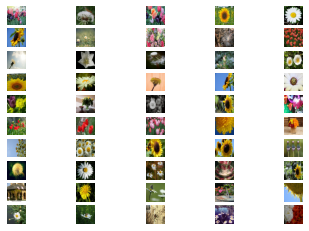

In [22]:
%matplotlib inline
plt.figure()
for i in range(len(np_img_holder)):
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    imshow(np.asarray(np_img_holder[i]))

For single tet file scoring, we need to add a dimension to one sample. Since a given image is of shape (224, 224, 3), we need to make it into (1, 224, 224, 3) so it will be accepted by the model for scoring, as the model is built to handle batch scoring, it is expecting four dimensions with the first dimension being sample size. So let's use the first image in the batch as an example:

In [23]:
x = np.expand_dims(np_img_holder[0], axis=0)

In [24]:
x.shape

(1, 224, 224, 3)

Convert it to a tensor with type of float32:

In [25]:
xf = tf.dtypes.cast(x, tf.float32)

In [26]:
type(xf)

tensorflow.python.framework.ops.EagerTensor

## Mapping prediction to class name
I need to create a reverse lookup dictionary to map probability back to label. In other words, I want to find the index where maximum probability is positioned in the array. Map this position index to flower type. To create the lookup dictionary, I need to parse the TFRecord with feature descriptions to extract label indices and names.

In [27]:
feature_description = {
    'image/channels' :  tf.io.FixedLenFeature([], tf.int64),
    'image/class/label' :  tf.io.FixedLenFeature([], tf.int64),
    'image/class/text' : tf.io.FixedLenFeature([], tf.string),
    'image/colorspace' : tf.io.FixedLenFeature([], tf.string),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
}

def _parse_function(example_proto):
  return tf.io.parse_single_example(example_proto, feature_description)

parsd_ds = test_all_ds.map(_parse_function)

val_label_map = {}
# getting label mapping
for image_features in parsd_ds.take(30):
    label_idx = image_features['image/class/label'].numpy()
    label_str = image_features['image/class/text'].numpy().decode()
    if label_idx not in val_label_map:
        val_label_map[label_idx] = label_str

In [28]:
val_label_map

{4: 'tulips', 3: 'dandelion', 1: 'sunflowers', 2: 'daisy', 0: 'roses'}

## Scoring using quantized model
Earlier, we created a variable `tgt` to hold the file path object that points to the path where our reduced float16 TFLite is saved.

In [29]:
str(tgt)

'tflite_hybrid_model/converted_model_hybrid.tflite'

In [30]:
##Load the TFLite model and allocate tensors.
## tgt is the pathlib object referring to file path and <TFLITE_MODEL_NAME>.tflite
interpreter = tf.lite.Interpreter(model_path=str(tgt))
interpreter.allocate_tensors()

In [31]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [32]:
input_details[0]['shape']

array([  1, 224, 224,   3], dtype=int32)

In [33]:
output_details[0]['shape']

array([1, 5], dtype=int32)

In [34]:
input_details

[{'name': 'input_1',
  'index': 0,
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [35]:
output_details

[{'name': 'Identity',
  'index': 269,
  'shape': array([1, 5], dtype=int32),
  'shape_signature': array([-1,  5], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

### Scoring single image

In [36]:
# Test the model
input_data = np.array(np.expand_dims(np_img_holder[0], axis=0), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

In [37]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[2.2863119e-04 2.9729056e-06 3.2464095e-06 2.0322236e-06 9.9976307e-01]]


The last position has the highest probability. This position is index 4. We need to use `lookup` function to map this index to our label map.

In [38]:
def lookup(np_entry, dictionary):
    class_key = np.argmax(np_entry)
    return dictionary.get(class_key)

`lookup` functio returns the class name:

In [39]:
lookup(output_data, val_label_map)

'tulips'

The model predicts this image is `tulips` class.

### Scoring image batch
We need to get the actual labels and put these true labels in a list.

In [47]:
actual = []
for i in range(len(np_lbl_holder)):
    class_key = np.argmax(np_lbl_holder[i])
    actual.append(val_label_map.get(class_key))

Then we create a function `batch_predict` for batch scoring.

In [48]:
def batch_predict(input_raw, input_tensor, output_tensor, dictionary):
    input_data = np.array(np.expand_dims(input_raw, axis=0), dtype=np.float32)
    interpreter.set_tensor(input_tensor[0]['index'], input_data)
    interpreter.invoke()
    interpreter_output = interpreter.get_tensor(output_tensor[0]['index'])
    plain_text_label = lookup(interpreter_output, dictionary)
    return plain_text_label

We call `batch_predict` to score our test images and store predictions in a list `batch_quantized_prediction`.

In [41]:
batch_quantized_prediction = []
for i in range(sample_size):
    plain_text_label = batch_predict(np_img_holder[i], input_details, output_details, val_label_map)
    batch_quantized_prediction.append(plain_text_label)

Then we use `sklearn`'s `accuracy_score` to compare the prediction with the actual label list.

In [50]:
quantized_accuracy = accuracy_score(actual, batch_quantized_prediction)

In [51]:
print(quantized_accuracy)

0.8


The accuracy of our hybrid quantization model is 0.8.